In [126]:
import pandas as pd

# Load dataset
df = pd.read_csv('crime_dataset_india.csv')  # Replace with your actual path

# Inspect column names
print(df.columns.tolist())


['Report Number', 'Date Reported', 'Date of Occurrence', 'Time of Occurrence', 'City', 'Crime Code', 'Crime Description', 'Victim Age', 'Victim Gender', 'Weapon Used', 'Crime Domain', 'Police Deployed', 'Case Closed', 'Date Case Closed']


In [127]:
# Drop irrelevant columns
df = df.drop(columns=[
    'Report Number', 'Date Reported', 'Date of Occurrence', 'Time of Occurrence',
    'Case Closed', 'Date Case Closed'
], errors='ignore')  # Ignores columns that aren't in the dataset

# Check for missing values and target columns
print(df.isnull().sum()) 


City                    0
Crime Code              0
Crime Description       0
Victim Age              0
Victim Gender           0
Weapon Used          5790
Crime Domain            0
Police Deployed         0
dtype: int64


In [128]:
# Handle missing values (e.g., fill victim age with the median)
df['Victim Age'] = pd.to_numeric(df['Victim Age'], errors='coerce')
df['Victim Age'] = df['Victim Age'].fillna(df['Victim Age'].median())  # Fixed line

# Drop rows where the target column is missing
df = df.dropna(subset=['Crime Domain'])


In [129]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
label_encoders = {}
categorical_cols = ['City', 'Crime Description', 'Victim Gender', 'Weapon Used']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Encode target column
target_le = LabelEncoder()
df['Crime Domain'] = target_le.fit_transform(df['Crime Domain'])


In [130]:
from sklearn.model_selection import train_test_split

# Select features and target variable
X = df[['City', 'Crime Description', 'Victim Age', 'Victim Gender', 'Weapon Used', 'Police Deployed']]
y = df['Crime Domain']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [131]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(clf, X, y, cv=6, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean()} (+/- {cv_scores.std()})")


Cross-Validation Accuracy: 0.9506723911121729 (+/- 0.001612212627241003)


In [132]:
print(df['Crime Domain'].value_counts())


Crime Domain
1    22948
3    11472
0     3825
2     1915
Name: count, dtype: int64


In [133]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=7, min_samples_leaf=9, random_state=42)
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)



In [134]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print classification report
print(classification_report(y_test, y_pred, target_names=target_le.classes_))


Accuracy: 0.9479581673306773
                  precision    recall  f1-score   support

   Fire Accident       1.00      1.00      1.00       737
     Other Crime       0.92      1.00      0.96      4580
Traffic Fatality       1.00      1.00      1.00       393
   Violent Crime       1.00      0.82      0.90      2322

        accuracy                           0.95      8032
       macro avg       0.98      0.95      0.96      8032
    weighted avg       0.95      0.95      0.95      8032



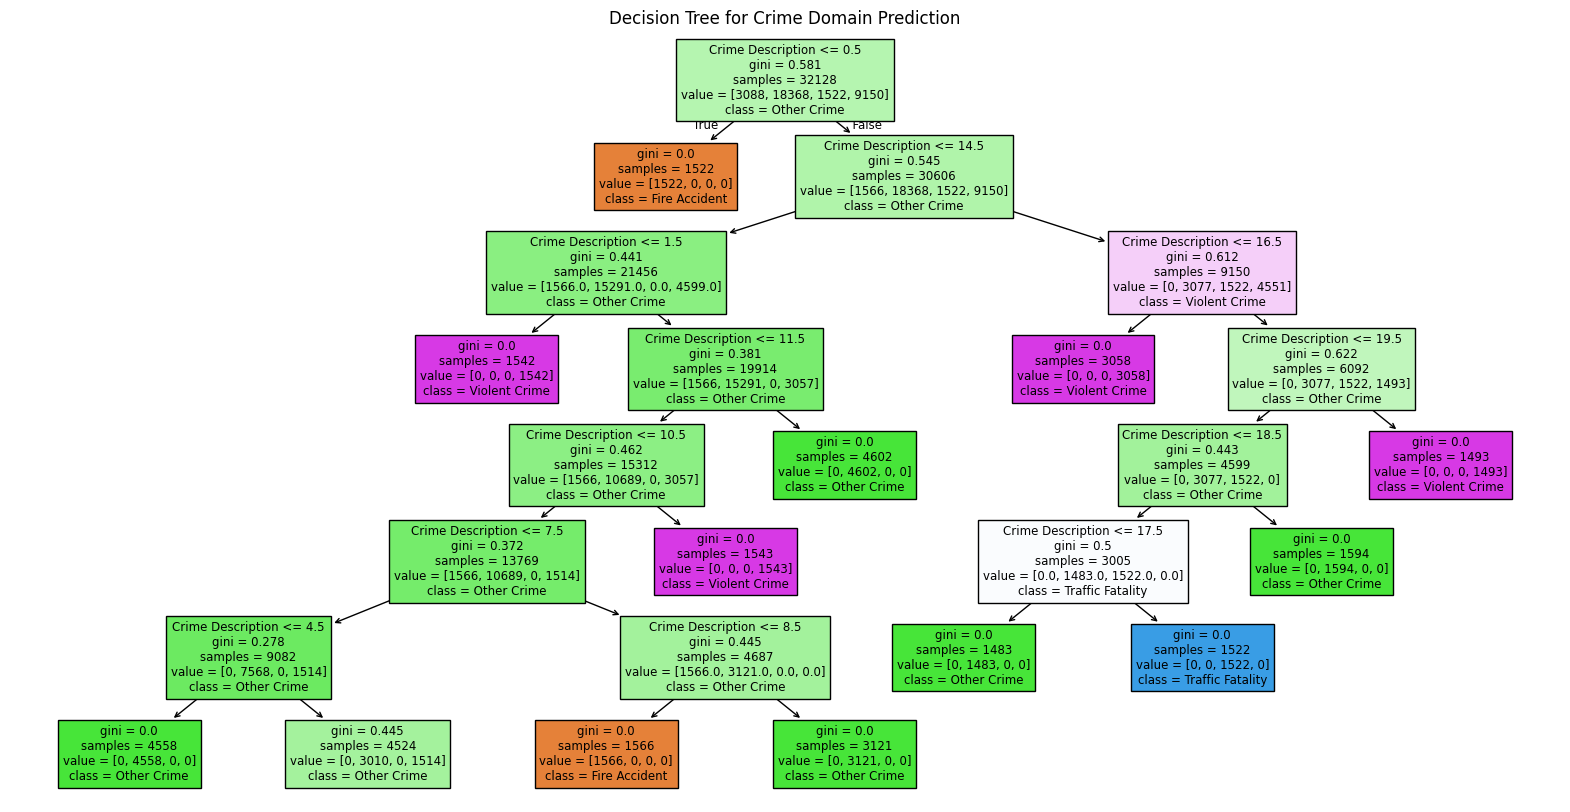

In [135]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.columns, class_names=target_le.classes_, filled=True)
plt.title("Decision Tree for Crime Domain Prediction")
plt.show()



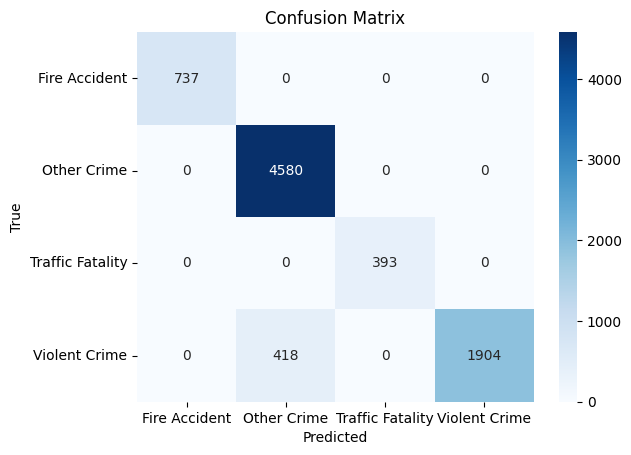

In [136]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_le.classes_, yticklabels=target_le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [137]:
from sklearn.tree import export_text

# Show how the model classifies by printing the decision tree rules
tree_rules = export_text(clf, feature_names=X.columns.tolist())
print("Decision Tree Classification Rules:\n", tree_rules)

Decision Tree Classification Rules:
 |--- Crime Description <= 0.50
|   |--- class: 0
|--- Crime Description >  0.50
|   |--- Crime Description <= 14.50
|   |   |--- Crime Description <= 1.50
|   |   |   |--- class: 3
|   |   |--- Crime Description >  1.50
|   |   |   |--- Crime Description <= 11.50
|   |   |   |   |--- Crime Description <= 10.50
|   |   |   |   |   |--- Crime Description <= 7.50
|   |   |   |   |   |   |--- Crime Description <= 4.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Crime Description >  4.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Crime Description >  7.50
|   |   |   |   |   |   |--- Crime Description <= 8.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Crime Description >  8.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- Crime Description >  10.50
|   |   |   |   |   |--- class: 3
|   |   |   |--- Crime Description >  11.50
|   |   |   |   |--- class: 1
|   |

In [138]:
# 1. Crime Prediction:
X_test_with_pred = X_test.copy()
X_test_with_pred['Predicted Crime Domain'] = target_le.inverse_transform(y_pred)
print("1. Crime Prediction - Sample of Predicted Crime Types:")
print(X_test_with_pred[['City', 'Victim Age', 'Predicted Crime Domain']].head(10))

1. Crime Prediction - Sample of Predicted Crime Types:
       City  Victim Age Predicted Crime Domain
11031    17          60            Other Crime
10506    17          40          Violent Crime
36398    13          36            Other Crime
3615      9          65            Other Crime
28121    17          56          Fire Accident
25495     8          72            Other Crime
28608     8          37          Fire Accident
3836     12          73            Other Crime
11288     4          62            Other Crime
17240    14          16          Violent Crime


In [139]:
# 2. Resource Allocation: Analyze predicted crime types by city to allocate resources
crime_by_city = X_test_with_pred.groupby(['City', 'Predicted Crime Domain']).size().unstack(fill_value=0)
print("\n2. Resource Allocation - Crime Types by City:")
print(crime_by_city)


2. Resource Allocation - Crime Types by City:
Predicted Crime Domain  Fire Accident  Other Crime  Traffic Fatality  \
City                                                                   
0                                  15           90                 5   
1                                  23          213                18   
2                                  69          469                30   
3                                   8           90                13   
4                                  51          305                27   
5                                 107          703                43   
6                                   7           44                 3   
7                                   9           92                11   
8                                  63          317                26   
9                                  11           85                10   
10                                 31          161                13   
11               

<Figure size 1000x600 with 0 Axes>

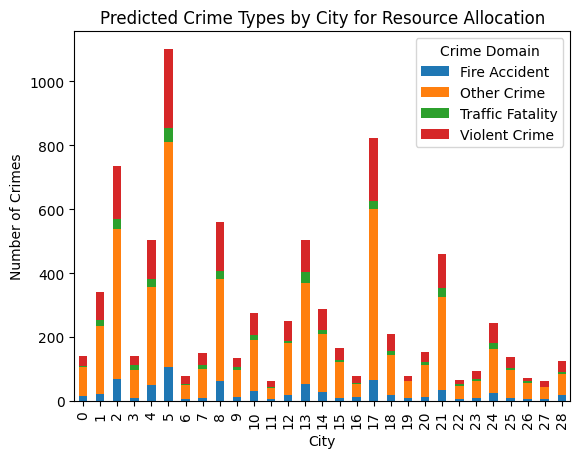

In [ ]:
plt.figure(figsize=(10, 6))
crime_by_city.plot(kind='bar', stacked=True)
plt.title('Predicted Crime Types by City for Resource Allocation')
plt.xlabel('City')
plt.ylabel('Number of Crimes')
plt.legend(title='Crime Domain')
plt.show()